# Giải thuật Simulated Annealing

Đối với Simulated Annealing, giải thuật có xác suất cho phép một kết quả tệ hơn có cơ hội được chấp nhận sau mỗi lần duyệt. Vì thế nó có khả năng thoát khỏi các cực trị địa phương và đi tìm một lời giải tối ưu hơn. Và xác suất chấp nhận này sẽ nhỏ dần (probability-decay) theo thời gian chạy của giải thuật. Do đó nên việc chấp nhận 1 kết quả tệ hơn sẽ ngày càng thấp,  lúc này giải thuật sẽ ưu tiên đi tìm điểm tối ưu nhất của vùng hiện tại. 

Trong thuật toán Simulated Annealing, xác suất chấp nhận một giải pháp kém hơn được tính bằng hàm số mũ. Công thức tổng quát cho xác suất này là:

$$
P(\Delta E) = e^{-\frac{\Delta E}{T}}
$$

Trong đó:

- $P(\Delta E)$ là xác suất chấp nhận giải pháp kém hơn.
- $\Delta E$ là sự thay đổi trong hàm mục tiêu (năng lượng) giữa giải pháp mới và giải pháp hiện tại.
- $T$ là nhiệt độ hiện tại của hệ thống.

Nhiệt độ $T$ thường giảm dần theo thời gian, điều này làm giảm xác suất chấp nhận các giải pháp kém hơn khi thuật toán tiến đến các bước cuối cùng.



Giải thuật Simulated Annealing sẽ hữu hiệu nhất trong trường hợp thêm hàm loss rất phức tạp có nhiều tham số cần hiệu chỉnh

In [4]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [29]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('data.csv')

# Phân loại các bác sĩ và điều dưỡng
doctors1 = data[data['Position'] == 1].to_dict(orient='records')
doctors2 = data[data['Position'] == 2].to_dict(orient='records')
nurses = data[data['Position'] == 3].to_dict(orient='records')

# Tổng số ca trực cần xếp trong 2 tháng
total_shifts = 62

# Hàm mất mát
def loss_function(schedule, data, alpha1=1, alpha2=1, alpha3=1):
    n = len(data)
    m = total_shifts
    A = np.zeros(n)
    K = np.zeros(m)
    
    for i in range(m):
        doctors_in_shift = [schedule[i][0], schedule[i][1]]
        departments_in_shift = set()
        
        for doc_id in doctors_in_shift:
            departments_in_shift.add(data.iloc[doc_id - 1]["Department"])
        
        K[i] = len(departments_in_shift)
        
        for doc_id in doctors_in_shift:
            A[doc_id - 1] += 1
    
    mu_K = np.mean(K)
    mu_A = np.mean(A)
    
    term1 = alpha1 * np.sum((A - mu_A) ** 2)
    term2 = alpha2 * np.sum((4 - K) ** 2)
    
    points = data['Point']
    mu_dtnbs = np.mean(points[data['Position'] == 1])
    mu_dtnbsII = np.mean(points[data['Position'] == 2])
    mu_dtndd = np.mean(points[data['Position'] == 3])
    
    term3 = 0
    for i in range(m):
        points_in_shift = [points[schedule[i][j] - 1] for j in range(4)]
        mean_points_in_shift = np.mean(points_in_shift)
        term3 += (mean_points_in_shift - (mu_dtnbs + mu_dtnbsII + 2 * mu_dtndd) / 4) ** 2
    
    return term1 + term2 + alpha3 * term3

# Hàm tạo lịch làm việc ngẫu nhiên
def generate_random_schedule(data, total_shifts):
    schedule = np.zeros((total_shifts, 4), dtype=int)
    
    for i in range(total_shifts):
        schedule[i][0] = random.choice(doctors1)["ID"]
        schedule[i][1] = random.choice(doctors2)["ID"]
        schedule[i][2] = random.choice(nurses)["ID"]
        schedule[i][3] = random.choice(nurses)["ID"]
    
    return schedule

# Simulated Annealing
def simulated_annealing(data, total_shifts, initial_temp=1000, cooling_rate=0.995, iterations=10000):
    current_schedule = generate_random_schedule(data, total_shifts)
    current_loss = loss_function(current_schedule, data)
    
    best_schedule = current_schedule
    best_loss = current_loss
    
    temperatures = []
    losses = []
    
    start_time = time.time()  # Bắt đầu đếm thời gian

    for i in range(iterations):
        # Tạo lịch mới bằng cách thay đổi ngẫu nhiên một số ca
        new_schedule = current_schedule.copy()
        shift_to_change = random.randint(0, total_shifts - 1)
        new_schedule[shift_to_change] = [
            random.choice(doctors1)["ID"],
            random.choice(doctors2)["ID"],
            random.choice(nurses)["ID"],
            random.choice(nurses)["ID"]
        ]
        
        new_loss = loss_function(new_schedule, data)
        delta_loss = new_loss - current_loss
        
        if delta_loss < 0 or np.random.rand() < np.exp(-delta_loss / initial_temp):
            current_schedule = new_schedule
            current_loss = new_loss
            
            if current_loss < best_loss:
                best_loss = current_loss
                best_schedule = current_schedule
        
        initial_temp *= cooling_rate
        
        # Lưu dữ liệu để vẽ biểu đồ
        temperatures.append(initial_temp)
        losses.append(best_loss)
    
    end_time = time.time()  # Kết thúc đếm thời gian
    elapsed_time = end_time - start_time  # Tính thời gian đã trôi qua

    # Tạo DataFrame cho các kết quả
    df_results = pd.DataFrame({
        'Iteration': range(1, iterations + 1),
        'Temperature': temperatures,
        'Best Loss': losses
    })

    # Tạo DataFrame cho lịch làm việc tốt nhất
    best_schedule_df = pd.DataFrame(best_schedule, columns=['Doc1_ID', 'Doc2_ID', 'Nurse1_ID', 'Nurse2_ID'])
    best_schedule_df['Day'] = range(1, total_shifts + 1)

    # Thêm thông tin về tên, khoa và điểm thâm niên
    def get_info_by_id(id):
        info = data[data['ID'] == id].iloc[0]
        return info['Name'], info['Department'], info['Point']
    
    best_schedule_df[['Doc1_Name', 'Doc1_Department', 'Doc1_Point']] = best_schedule_df.apply(lambda row: get_info_by_id(row['Doc1_ID']), axis=1, result_type='expand')
    best_schedule_df[['Doc2_Name', 'Doc2_Department', 'Doc2_Point']] = best_schedule_df.apply(lambda row: get_info_by_id(row['Doc2_ID']), axis=1, result_type='expand')
    best_schedule_df[['Nurse1_Name', 'Nurse1_Department', 'Nurse1_Point']] = best_schedule_df.apply(lambda row: get_info_by_id(row['Nurse1_ID']), axis=1, result_type='expand')
    best_schedule_df[['Nurse2_Name', 'Nurse2_Department', 'Nurse2_Point']] = best_schedule_df.apply(lambda row: get_info_by_id(row['Nurse2_ID']), axis=1, result_type='expand')

    # Loại bỏ các cột ID
    best_schedule_df = best_schedule_df.drop(columns=['Doc1_ID', 'Doc2_ID', 'Nurse1_ID', 'Nurse2_ID'])

    return best_schedule_df, best_loss, df_results, elapsed_time

# Thực hiện tối ưu hóa và thu thập dữ liệu
best_schedule_df, best_loss, df_results, elapsed_time = simulated_annealing(data, total_shifts)

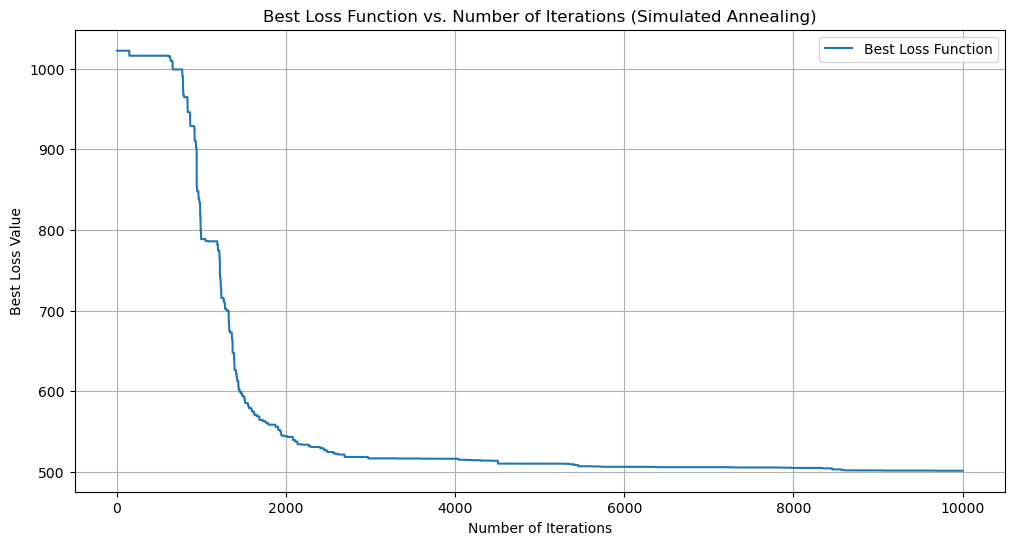

Best Loss: 501.61249999999995
Elapsed Time: 81.99 seconds


In [30]:
# Vẽ biểu đồ từ DataFrame và lưu vào file
plt.figure(figsize=(12, 6))
plt.plot(df_results['Iteration'], df_results['Best Loss'], label='Best Loss Function')
plt.xlabel('Number of Iterations')
plt.ylabel('Best Loss Value')
plt.title('Best Loss Function vs. Number of Iterations (Simulated Annealing)')
plt.legend()
plt.grid(True)

# Lưu biểu đồ vào file ảnh
plt.savefig('best_loss_vs_iterations_sa.png')

plt.show()

print(f"Best Loss: {best_loss}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

In [31]:
# Đặt 'Day' làm chỉ mục của DataFrame kết quả3
best_schedule_df.set_index('Day', inplace=True)

# Hiển thị DataFrame kết quả
best_schedule_df

,Doc1_Name,Doc1_Department,Doc1_Point,Doc2_Name,Doc2_Department,Doc2_Point,Nurse1_Name,Nurse1_Department,Nurse1_Point,Nurse2_Name,Nurse2_Department,Nurse2_Point
Day,,,,,,,,,,,,
1,Bắc,Emergency,9,Thắng,Internal,9,Thành,Clinical,22,An,Internal,2
2,Xuân,Emergency,18,Minh Phương,Clinical,16,Dung,Emergency,5,Minh,Emergency,4
3,Linh,External,13,Thắng,Internal,9,Tơ,Internal,7,Len,Emergency,9
4,Sơn,Internal,8,Giang,External,10,Thành,Clinical,22,Hương,Clinical,2
5,Trang,External,15,Dung,Clinical,7,Kim Anh,Clinical,6,Huệ,External,12
...,...,...,...,...,...,...,...,...,...,...,...,...
58,Bá Tuấn,Clinical,16,Phượng,External,1,Huyền,Internal,20,Minh,Emergency,4
59,Hường,Internal,3,Thuận,External,8,Dương,Internal,10,Huyền,Internal,20
60,Tâm,Emergency,17,Hưng,Internal,4,Tuyến,Internal,16,An,Internal,2


In [32]:
best_schedule_df[['Doc1_Name', 'Doc1_Department', 'Doc2_Name', 'Doc2_Department', 'Nurse1_Name', 'Nurse1_Department', 'Nurse2_Name', 'Nurse2_Department']].head(10)

,Doc1_Name,Doc1_Department,Doc2_Name,Doc2_Department,Nurse1_Name,Nurse1_Department,Nurse2_Name,Nurse2_Department
Day,,,,,,,,
1,Bắc,Emergency,Thắng,Internal,Thành,Clinical,An,Internal
2,Xuân,Emergency,Minh Phương,Clinical,Dung,Emergency,Minh,Emergency
3,Linh,External,Thắng,Internal,Tơ,Internal,Len,Emergency
4,Sơn,Internal,Giang,External,Thành,Clinical,Hương,Clinical
5,Trang,External,Dung,Clinical,Kim Anh,Clinical,Huệ,External
6,Ngân Hà,External,Hùng,Emergency,Yên,External,Huệ,External
7,Ngân Hà,External,Hà,Clinical,Linh,Internal,Thành,Clinical
8,Bá Tuấn,Clinical,Dũng,Emergency,Chí Đức,External,Long,Emergency
9,Bằng,Clinical,Vân Anh,Emergency,Huệ,External,Linh,Internal


In [33]:
# Lưu DataFrame kết quả vào file CSV

best_schedule_df.to_csv('best_schedule_sa_improved.csv', index=False)